# Figures 1 and 2 : Topography of MAR and warming in the Alps as a function of global warming
Use the phd_v3 environment (can be replicated from the .yml file in envs/)

In [1]:
import xarray as xr
#import rioxarray as rxr
import xesmf as xe
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter
from scipy import interpolate

from pyproj import CRS,Transformer,Proj

import sys
sys.path.insert(1, '/home/castelli/Notebooks/PhD/utils') # to include my util file in previous directory
import utils as u
u.check_python_version()

3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]


In [2]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/MARgrid_EUe.nc')

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
lon = np.array(ds.LON[jmin:jmax,imin:imax])
lat = np.array(ds.LAT[jmin:jmax,imin:imax])
H = np.array(ds.SH[jmin:jmax,imin:imax])
nlat,nlon = 91, 139

normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True,
                 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
big_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True,
              'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[41.,50],'lonlim':[0.,20.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2,
                    'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']



In [3]:
ds_v314 = xr.open_dataset('/bettik/castelli/MARout/EUn/n01/2014/ICE.n01.2014.09.01-30.nc')[["LON","LAT","SH","FRV","VEG"]]

In [4]:
def detect_alps(H):
    nlat,nlon = np.shape(H)
    mask = np.bool_(np.zeros((nlat,nlon)))
    r = 4
    for j in range(r,nlat-r):
        for i in range(r,nlon-r):
            mask[j,i] = np.logical_and(H[j,i]>360 ,np.any(H[j-r:j+r,i-r:i+r]>1300))
            # mask[j,i] = np.std(H[j-r:j+r,i-r:i+r])>200
    return mask
alps = detect_alps(H)
alps[lon<4.8] = False
alps[np.logical_and(lon>10,lat<45.2)] = False

alps_month = np.repeat(alps[np.newaxis,:,:],12,axis=0)

In [5]:
# function for seasonal mean (from Ian)
def season_mean(ds, calendar="standard"):
    #make a DataArray with the season of each day
    seas_array = ds.time.dt.season
    
    # count days in winter season (varies with leap years)
    nb_DJF = seas_array.str.count('DJF').sum()
    
    wgt_DJF = 1/nb_DJF.values.item()
    wgt_MAM = 1/(31+30+31)
    wgt_JJA = 1/(30+31+31)
    wgt_SON = 1/(30+31+30)

    weight = seas_array.str.replace('DJF',str(wgt_DJF)).str.replace('MAM',str(wgt_MAM)).str.replace('JJA',str(wgt_JJA)).str.replace('SON',str(wgt_SON))
    weight = weight.astype('float')
    
    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weight.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weight).groupby("time.season").sum(dim="time")

In [6]:
def spline(knots, x, y):
    x_new = np.linspace(0, 1, knots+2)[1:-1]
    q_knots = np.quantile(x, x_new)
    t, c, k = interpolate.splrep(x, y, t=q_knots)
    print(k)
    yfit = interpolate.BSpline(t,c, k)(x)
    return yfit

## Figure 1 : topography

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


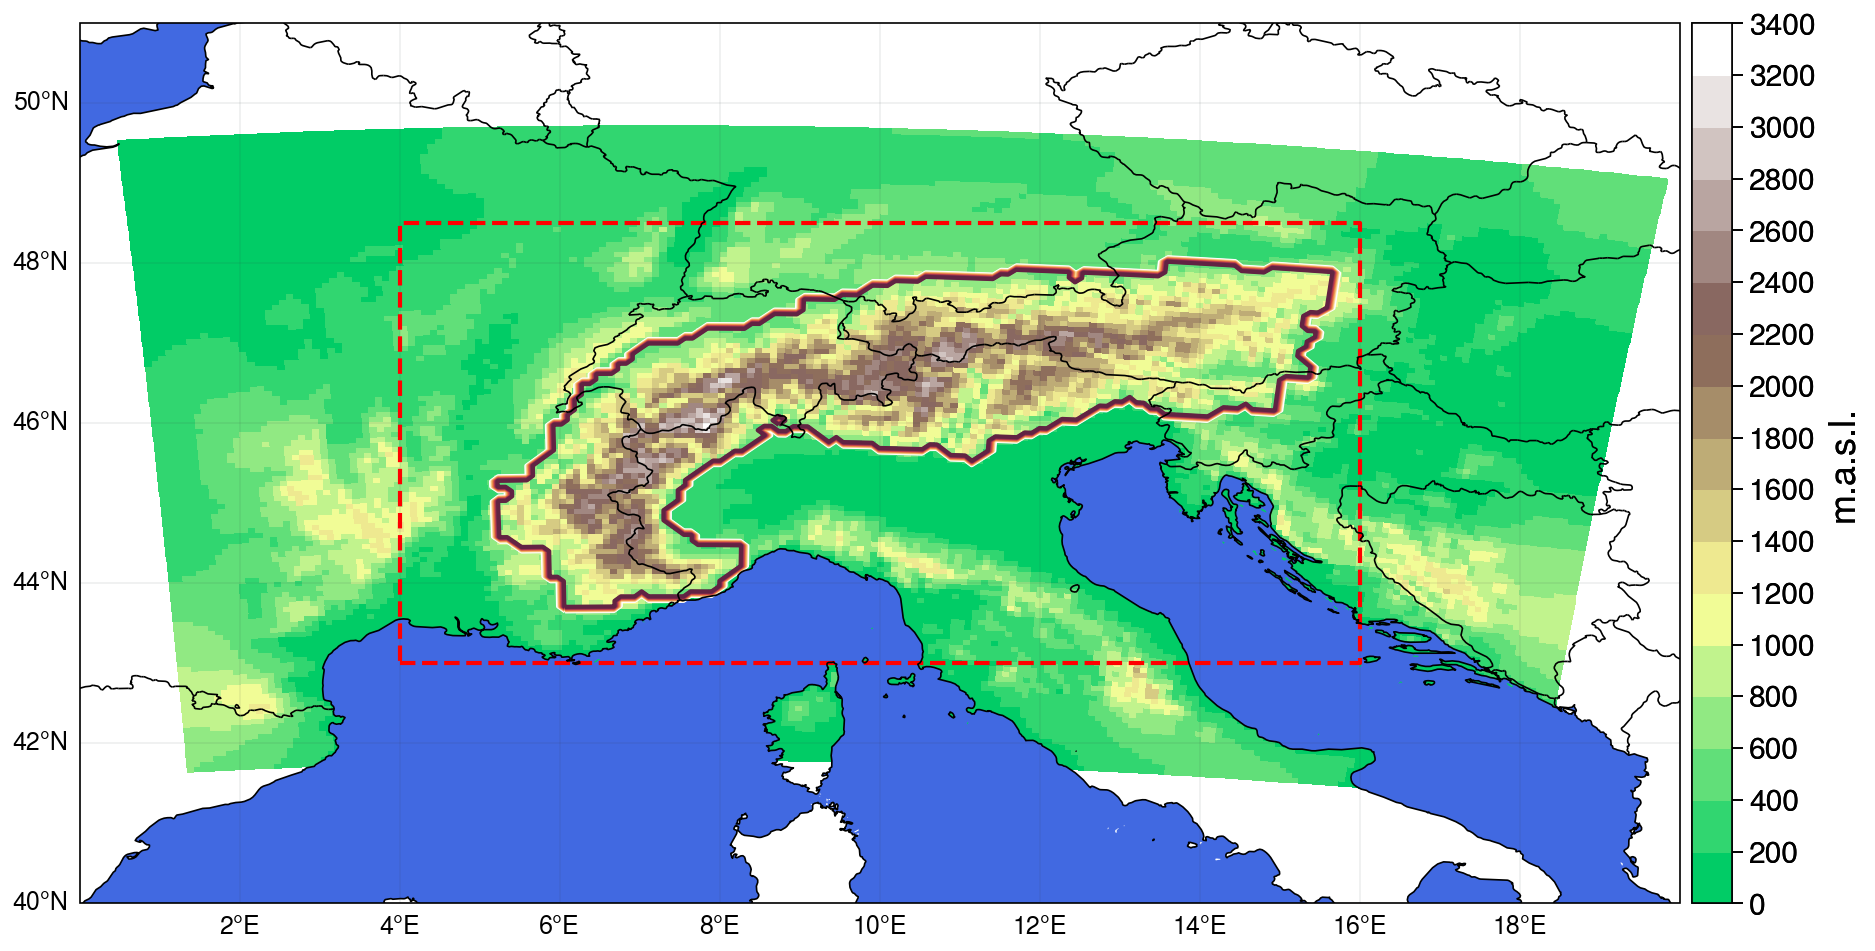

In [7]:
pplt.rc['figure.facecolor'] = 'white'

colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
f, axs = pplt.subplots(proj='cyl', axwidth=8,ncols=1)

m=axs.pcolormesh(ds.LON, ds.LAT, ds.SH, levels=17,cmap=colors_land)
axs.colorbar(m,label= 'm.a.s.l.',labelsize='x-large',ticklabelsize='large')
axs.plot([4.,16.,16,4,4],[43.,43,48.5,48.5,43],'--r')
axs.contour(lon, lat, alps)

f.format(**normal_format)
f.format(ocean=True,oceancolor='royalblue',reso='hi', latlim=[40.,51.],lonlim=[0.,20.])


## Figure 2 a/b/c/d/e

### Preparing MAR data

In [ ]:
# -------------------------------------------------------   EC-Earth3 SSP2-4.5   -----------------------------------------------------
# wp = whole period

first_year = 1961
last_year = 2100
wp_meanseason_meanT = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    if year <2015:
        ds_mean = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.TTz.'+str(year)+'.nc')
    else:
        ds_mean = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.TTz.'+str(year)+'.nc')
    season_mean_year=season_mean(ds_mean.TTz.isel(ztqlev=0)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanT[year-first_year] = season_mean_year

np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanT.npy', wp_meanseason_meanT)


In [ ]:
# -------------------------------------------------------   MPI-ESM1-2-HR SSP2-4.5   -----------------------------------------------------
# wp = whole period

name_GCM = 'MPI-ESM1-2-HR'
code_GCM = 'MPI-ESM'
scenario = 'SSP245'
sim = 'EUy'
sim2 = 'EUv'

data_freq = 'daily'
data_freq_prefix = 'ICE' # ICE for daily, MON for monthly

first_year = 1961
last_year = 2100

# ----------------------------------------------

Tmean_seas = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    #if year == 1985 or year == 2071:
    #    continue
    hist_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/HIST/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_HIST.'+sim+'.TTz.'+str(year)+'.nc'
    ssp245_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP245/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP245.'+sim2+'.TTz.'+str(year)+'.nc'
    if year <2015:
        ds_var = xr.open_dataset(hist_path)
    else:
        #ds_T = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/monthly/MON.EC-Earth3_SSP245.EUe.TTz.'+str(year)+'.nc')
        ds_var = xr.open_dataset(ssp245_path)

    season_mean_year=season_mean(ds_var.TTz.isel(ztqlev=0)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    Tmean_seas[year-first_year] = season_mean_year

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_meanT.npy', Tmean_seas)

In [ ]:
# -------------------------------------------------------   MPI-ESM1-2-HR SSP5-8.5   -----------------------------------------------------
# wp = whole period

name_GCM = 'MPI-ESM1-2-HR'
code_GCM = 'MPI-ESM'
scenario = 'SSP585'
sim = 'EUy'
sim2 = 'EUy'

data_freq = 'daily'
data_freq_prefix = 'ICE' # ICE for daily, MON for monthly

first_year = 2015
last_year = 2100

# ----------------------------------------------

Tmean_seas = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')

    ssp585_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP585/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP585.'+sim2+'.TTz.'+str(year)+'.nc'

    ds_var = xr.open_dataset(ssp585_path)

    season_mean_year=season_mean(ds_var.TTz.isel(ztqlev=0)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    Tmean_seas[year-first_year] = season_mean_year

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/wp_meanseason_meanT.npy', Tmean_seas)

### Loading prepared MAR data

In [8]:
wp_meanseason_meanT = np.load('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanT.npy')[:,:,jmin:jmax,imin:imax]

wp_meanseason_meanT.shape

(140, 4, 91, 139)

In [9]:
wp_meanseason_meanT_245 = np.load('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_meanT.npy')[:,:,jmin:jmax,imin:imax]

wp_meanseason_meanT_585 = np.copy(wp_meanseason_meanT_245)
fp_meanseason_meanT_585 = np.load('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/fp_meanseason_meanT.npy')[:,:,jmin:jmax,imin:imax]
wp_meanseason_meanT_585[54:,:,:,:] = fp_meanseason_meanT_585

### Loading and preparing GCM data

In [8]:
ds_MPIhist = xr.open_dataset('/bettik/castelli/data/MPI-ESM1-2-HR/MPI-ESM1-2-HR_historical_r1i1p1f1_gn_185001-201412.nc')
ds_MPI245 = xr.open_dataset('/bettik/castelli/data/MPI-ESM1-2-HR/MPI-ESM1-2-HR_ssp245_r1i1p1f1_gn_201501-210012.nc')
ds_MPI585 = xr.open_dataset('/bettik/castelli/data/MPI-ESM1-2-HR/MPI-ESM1-2-HR_ssp585_r1i1p1f1_gn_201501-210012.nc')

In [9]:
ds_ECEarth_hist = xr.open_dataset('/bettik/castelli/data/EC-Earth3/tas_Amon_EC-Earth3_hist_r25i1p1f1_gr_185001-201412.nc')
ds_ECEarth_245 = xr.open_dataset('/bettik/castelli/data/EC-Earth3/tas_Amon_EC-Earth3_ssp245_r25i1p1f1_gr_201501-210012.nc')

Spatially average GCM data over the whole globe, using function in folder utils :

In [10]:
yrly_tas_MPIhist_globalmean = u.spatial_average(ds_MPIhist.tas.groupby("time.year").mean("time")) - 273.16
yrly_tas_MPI245_globalmean = u.spatial_average(ds_MPI245.tas.groupby("time.year").mean("time")) - 273.16
yrly_tas_MPI585_globalmean = u.spatial_average(ds_MPI585.tas.groupby("time.year").mean("time")) - 273.16


In [11]:
yrly_tas_ECEarth_245_globalmean = u.spatial_average(ds_ECEarth_245.tas.groupby("time.year").mean("time")) - 273.16
yrly_tas_ECEarth_hist_globalmean = u.spatial_average(ds_ECEarth_hist.tas.groupby("time.year").mean("time")) - 273.16

In [12]:
yrly_tas_ECEarth_globalmean = np.concatenate([yrly_tas_ECEarth_hist_globalmean,yrly_tas_ECEarth_245_globalmean])
yrly_tas_MPI2_globalmean = np.concatenate([yrly_tas_MPIhist_globalmean,yrly_tas_MPI245_globalmean])
yrly_tas_MPI5_globalmean = np.concatenate([yrly_tas_MPIhist_globalmean,yrly_tas_MPI585_globalmean])

yrly_tas_ECEarth_globalmean.shape

(251,)

Fitting spline through time series :

In [13]:
kn = 4
yrly_tas_ECEarth_globalmean_spline = spline(kn,np.arange(1850,2101,1), yrly_tas_ECEarth_globalmean)
#np.save('/bettik/castelli/data/EC-Earth3/yrly_tas_ECEarth_spline_4k.npy', yfit)

yrly_tas_MPI245_globalmean_spline = spline(kn,np.arange(1850,2101,1), yrly_tas_MPI2_globalmean)
#np.save('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI245_spline_4k.npy', yfit)

yrly_tas_MPI585_globalmean_spline = spline(kn,np.arange(1850,2101,1), yrly_tas_MPI5_globalmean)
#np.save('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI585_spline_4k.npy', yfit)

3
3
3


Defining reference period :

In [12]:
# Reference period chosen as 1961-1990
refperiod_mean_MPI_spline = yrly_tas_MPI245_globalmean_spline[:30].mean()
print(refperiod_mean_MPI_spline)
refperiod_mean_ECEarth_spline = yrly_tas_ECEarth_globalmean_spline[:30].mean()
print(refperiod_mean_ECEarth_spline)

14.364232880986638
14.505953468321454


Text(0.5, 0.98, 'Spline global warming (reference period : 1961-1990)')

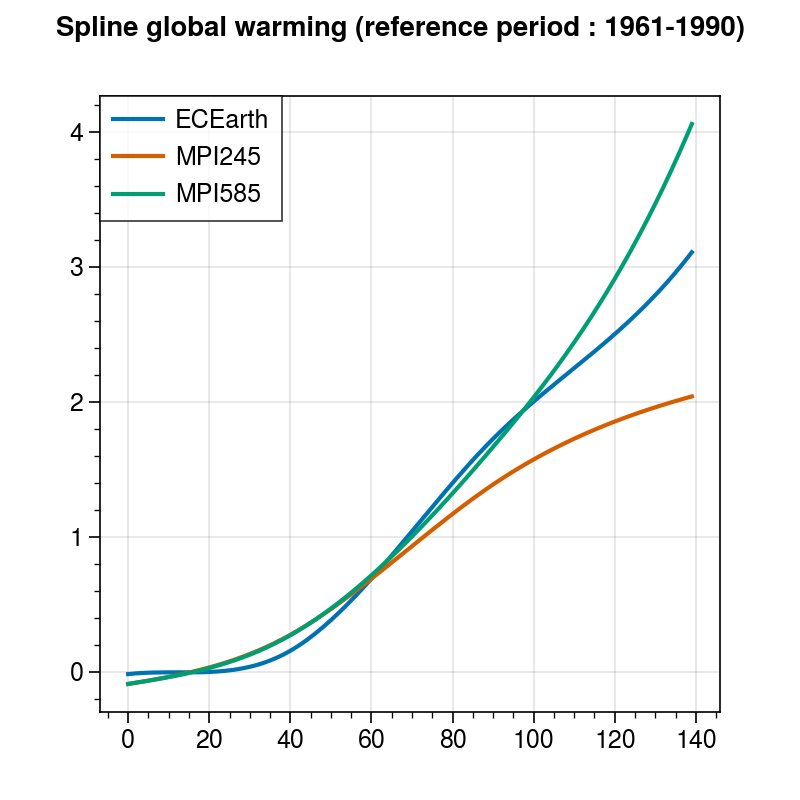

In [13]:
yrly_warming_ECEarth_spline = yrly_tas_ECEarth_globalmean_spline - refperiod_mean_ECEarth_spline

yrly_warming_MPI245_spline = yrly_tas_MPI245_globalmean_spline - refperiod_mean_MPI_spline
yrly_warming_MPI585_spline = yrly_tas_MPI585_globalmean_spline - refperiod_mean_MPI_spline

GCM_wrming_spline = np.concatenate([yrly_warming_ECEarth_spline,yrly_warming_MPI245_spline,yrly_warming_MPI585_spline[54:]])
GCM_wrming_spline_hist = np.concatenate([yrly_warming_ECEarth_spline[:54],yrly_warming_MPI245_spline[:54]])
GCM_wrming_spline_fut = np.concatenate([yrly_warming_ECEarth_spline[54:],yrly_warming_MPI245_spline[54:],yrly_warming_MPI585_spline[54:]])



plt.plot(yrly_warming_ECEarth_spline,label='ECEarth')
plt.plot(yrly_warming_MPI245_spline,label='MPI245')
plt.plot(yrly_warming_MPI585_spline,label='MPI585')

plt.legend()
plt.suptitle('Spline global warming (reference period : 1961-1990)')

### Linear regression of MAR warming with respect to GCM warming (all three MARv3.10 simulations together)

In [14]:
# Concatenate the simulations together

MAR_wrming_season_map = np.concatenate((wp_meanseason_meanT,wp_meanseason_meanT_245,fp_meanseason_meanT_585),axis=0)
MAR_wrming_season_map_hist = np.concatenate((wp_meanseason_meanT[:54],wp_meanseason_meanT_245[:54]),axis=0)
MAR_wrming_season_map_fut = np.concatenate((wp_meanseason_meanT[54:],wp_meanseason_meanT_245[54:],fp_meanseason_meanT_585),axis=0)


MAR_wrming_yr_map = np.concatenate((wp_meanseason_meanT.mean(axis=1),wp_meanseason_meanT_245.mean(axis=1),fp_meanseason_meanT_585.mean(axis=1)),axis=0)
MAR_wrming_yr_map_hist = np.concatenate((wp_meanseason_meanT[:54].mean(axis=1),wp_meanseason_meanT_245[:54].mean(axis=1)),axis=0)
MAR_wrming_yr_map_fut = np.concatenate((wp_meanseason_meanT[54:].mean(axis=1),wp_meanseason_meanT_245[54:].mean(axis=1),fp_meanseason_meanT_585.mean(axis=1)),axis=0)


slope_linregress_yr_map = []
origin_linregress_yr_map = []
slope_linregress_yr_map_hist = []
origin_linregress_yr_map_hist = []
slope_linregress_yr_map_fut = []
origin_linregress_yr_map_fut = []

slope_linregress_season_map = []
origin_linregress_season_map = []

slope_linregress_season_map_hist = []
origin_linregress_season_map_hist = []

slope_linregress_season_map_fut = []
origin_linregress_season_map_fut = []

r = np.linalg.lstsq(np.c_[GCM_wrming_spline, np.ones_like(GCM_wrming_spline)], MAR_wrming_yr_map.reshape(MAR_wrming_yr_map.shape[0],91*139),rcond=None)[0]
slope_linregress_yr_map.append(r[0].reshape(91,139))
origin_linregress_yr_map.append(r[1].reshape(91,139))

r = np.linalg.lstsq(np.c_[GCM_wrming_spline_hist, np.ones_like(GCM_wrming_spline_hist)], 
                    MAR_wrming_yr_map_hist.reshape(MAR_wrming_yr_map_hist.shape[0],91*139),rcond=None)[0]
slope_linregress_yr_map_hist.append(r[0].reshape(91,139))
origin_linregress_yr_map_hist.append(r[1].reshape(91,139))

r = np.linalg.lstsq(np.c_[GCM_wrming_spline_fut, np.ones_like(GCM_wrming_spline_fut)], MAR_wrming_yr_map_fut.reshape(MAR_wrming_yr_map_fut.shape[0],91*139),rcond=None)[0]
slope_linregress_yr_map_fut.append(r[0].reshape(91,139))
origin_linregress_yr_map_fut.append(r[1].reshape(91,139))

for seas in range(4):
    seas_array_reshaped = MAR_wrming_season_map[:,seas].reshape(MAR_wrming_season_map.shape[0],91*139)
    r = np.linalg.lstsq(np.c_[GCM_wrming_spline, np.ones_like(GCM_wrming_spline)], seas_array_reshaped,rcond=None)[0]
    slope_linregress_season_map.append(r[0].reshape(91,139))
    origin_linregress_season_map.append(r[1].reshape(91,139))

    seas_array_reshaped = MAR_wrming_season_map_hist[:,seas].reshape(MAR_wrming_season_map_hist.shape[0],91*139)
    r = np.linalg.lstsq(np.c_[GCM_wrming_spline_hist, np.ones_like(GCM_wrming_spline_hist)], seas_array_reshaped,rcond=None)[0]
    slope_linregress_season_map_hist.append(r[0].reshape(91,139))
    origin_linregress_season_map_hist.append(r[1].reshape(91,139))

    seas_array_reshaped = MAR_wrming_season_map_fut[:,seas].reshape(MAR_wrming_season_map_fut.shape[0],91*139)
    r = np.linalg.lstsq(np.c_[GCM_wrming_spline_fut, np.ones_like(GCM_wrming_spline_fut)], seas_array_reshaped,rcond=None)[0]
    slope_linregress_season_map_fut.append(r[0].reshape(91,139))
    origin_linregress_season_map_fut.append(r[1].reshape(91,139))

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

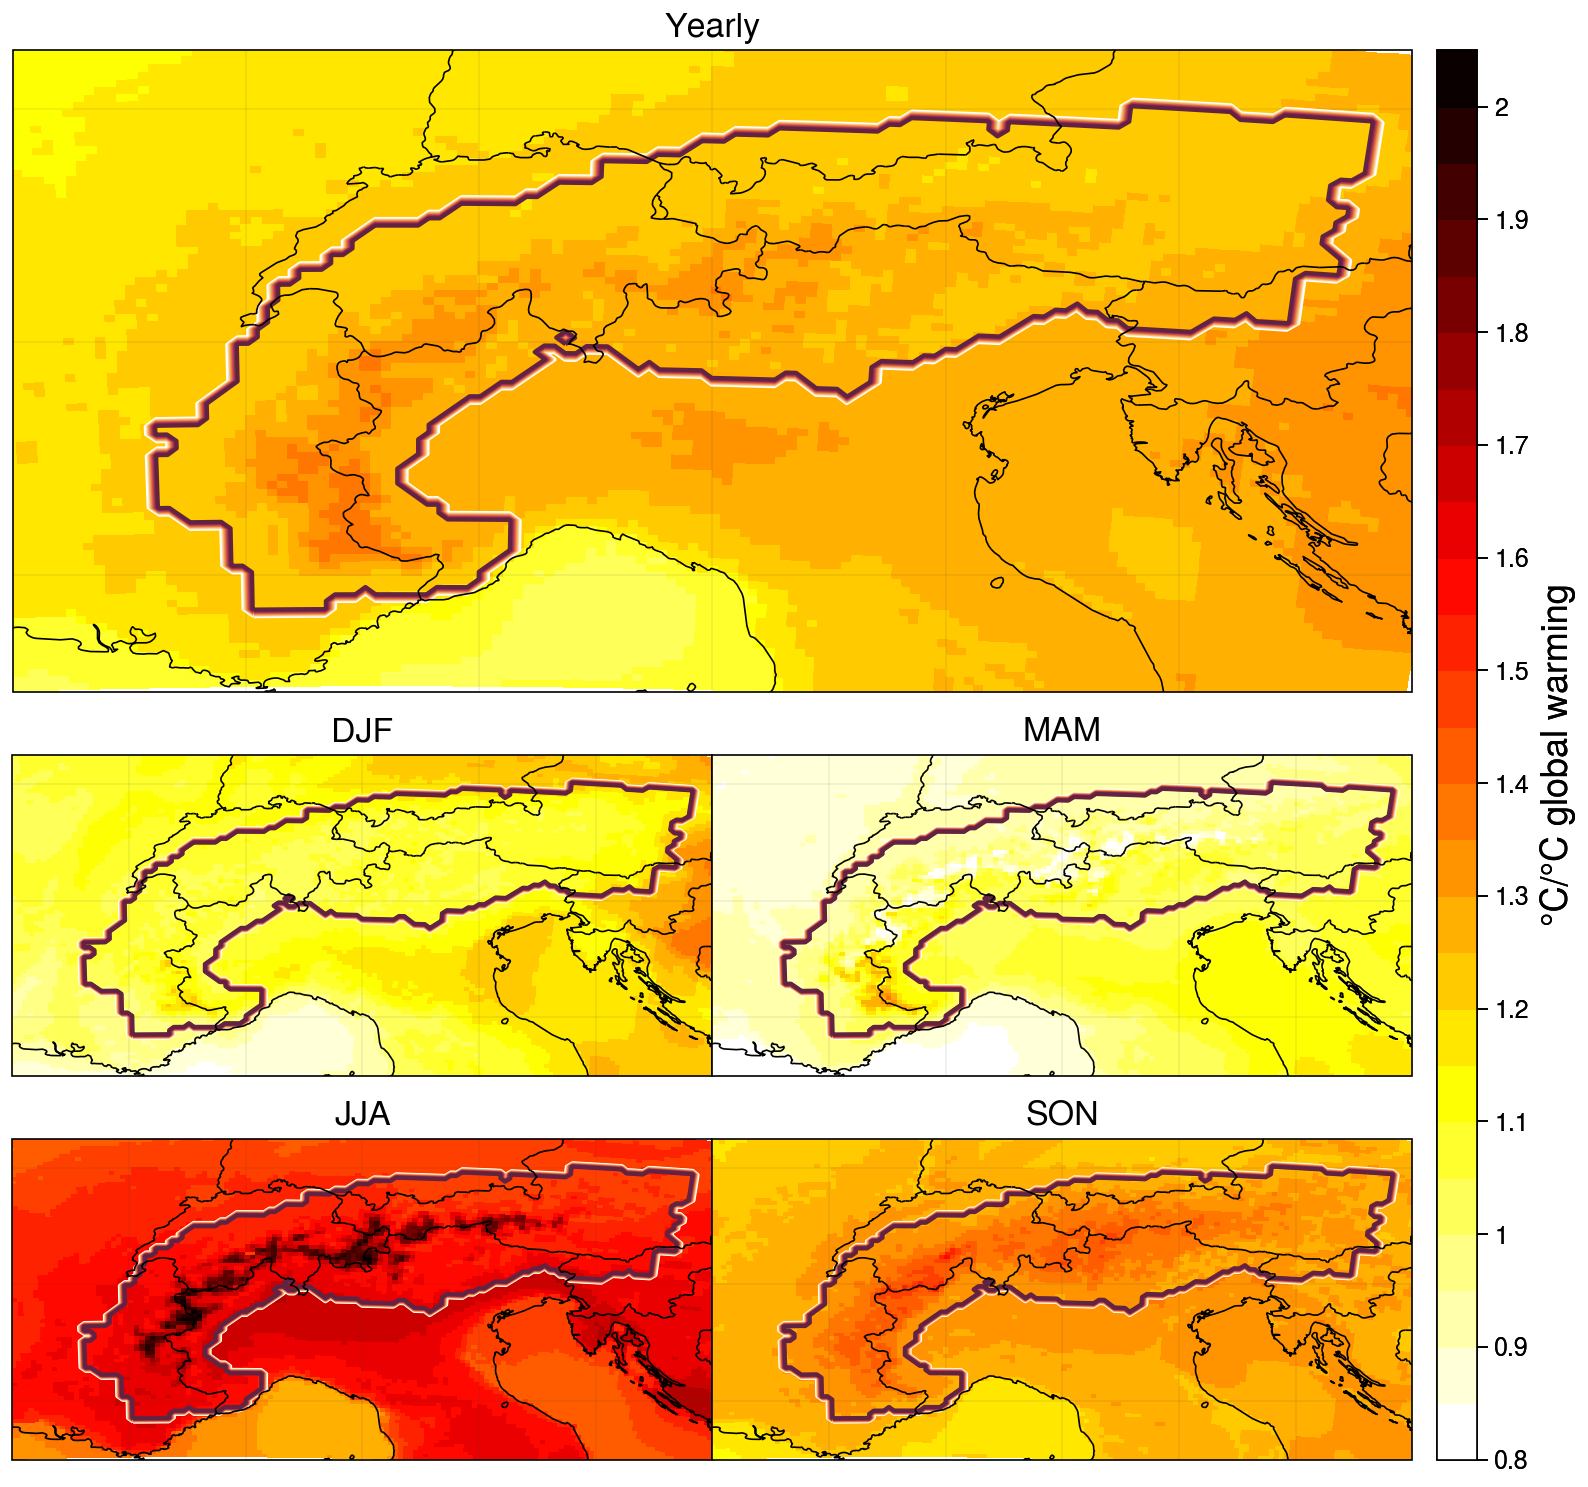

In [15]:
colmap = 'hot_r'
## Normalize so that 1 is the "pivot"
#norm = mcolors.TwoSlopeNorm(vmin=0., vcenter=1.0, vmax=2.)

f, axs = pplt.subplots([[1, 1], [1, 1], [2, 3], [4, 5]], refnum=1, refwidth=7, proj='cyl')#,axwidth=3)

#lvls_range = np.linspace(0.75,1.75,21)
lvls_range = np.linspace(0.8,2.05,26)

m = axs[0].pcolormesh(lon,lat,slope_linregress_yr_map[0],levels=lvls_range,cmap=colmap)#,norm=norm)
axs[0].contour(lon, lat,alps)
axs[0].format(title='Yearly',titlesize='17px')

for seas in [1,2,3,4]:
    axs[seas].pcolormesh(lon,lat,slope_linregress_season_map[seas-1],levels=lvls_range,cmap=colmap)#,norm=norm)
    axs[seas].format(title=['DJF','MAM','JJA','SON'][seas-1],titlesize='17px')
    axs[seas].contour(lon, lat,alps)

f.colorbar(m, label= '°C/°C global warming',labelsize='x-large',ticks=0.1)

axs.format(**multiplot_format)#,suptitle="Year",suptitlesize='16px')